# Agent Scheduling Problem
This isn't the classic Traveling Salesman Problem with Time Windows because there are more constraints to respect.<br>
Those constraints are:
<ul>
    <li>30 minutes for lunch between 12:00 AM and 2:00 PM;</li>
    <li>Limited working time (8 hours);</li>
    <li>Limited waiting and traveling time;</li>
    <li>Minimum time to spent in office (1 hour);</li>
</ul>

## Model

## Model implementation

### Importing libraries

In [1]:
from gurobipy import*

import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

### Define file with clients data

In [2]:
FILE = "./TEST_SETS/test_2.txt"

### Define costant parameters

In [3]:
# Default params
SUPPORTED_FORMAT = ['NUM', 'X', 'Y', 'DEMAND', 'READYTIME', 'DUEDATE', 'SERVICE']
# Macros for time values conversions
MINUTES = 60
HOURS = 3600
OFFSET_TIMES = 8*HOURS

COLUMNS_OPS = {'NUM': lambda x: float(x),
               'X': lambda x: float(x),
               'Y': lambda x: float(x),
               'DEMAND': lambda x: 1,
               'READYTIME': lambda x: float(x),
               'DUEDATE': lambda x: float(x),
               'SERVICE': lambda x: float(x)
              }
# Agents count
AGENTS = 3

# Agent Working day start and end
WORKING_TIME_RANGE = (0, 8*HOURS)

# Agent Lunch break time range, lasting
LUNCH_BREAK_RANGE = (12*HOURS-OFFSET_TIMES, 13.5*HOURS-OFFSET_TIMES)
LUNCH_BREAK_TIME = 30*MINUTES

# Agents office parameters
OFFICE_NUM = 0
OFFICE_X = .0
OFFICE_Y = .0
OFFICE_READYTIME = WORKING_TIME_RANGE[0]
OFFICE_DUEDATE = WORKING_TIME_RANGE[1]
OFFICE_SERVICE = 1*HOURS

### Read clients data

In [4]:
def read_input_tsptw(filename):
    """ Function used to convert input file to usable data.
        :params filename: File to convert,
        :return: A dict with nodes parameters,
                 A distance matrix between nodes,
                 Nodes coordinates.
    """
    # Dict sed for locations parameters
    data_dict = dict()
    
    # List of node positions for plots
    nodes_x = list()
    nodes_y = list()
       
    # Add office to data
    data_dict.update({OFFICE_NUM: {'X': OFFICE_X, 
                                   'Y': OFFICE_Y, 
                                   'DEMAND': AGENTS,
                                   'READYTIME': OFFICE_READYTIME,
                                   'DUEDATE': OFFICE_DUEDATE,
                                   'SERVICE': OFFICE_SERVICE,}})
    # Add office to nodes
    nodes_x.append(OFFICE_X)
    nodes_y.append(OFFICE_Y)
    
    # Open file and read lines 
    with open(filename, "r") as file:
        # Initialize columns in empty dict
        columns = file.readline().replace("#","").split()
        if columns != SUPPORTED_FORMAT:
            print("ERROR! Format not supported.")
            return 
                   
        # For each data line
        for line in file.readlines():
            node_dict = {k: COLUMNS_OPS[k](val) for k, val in zip(columns, line.split())}
            # Get id
            node_id = node_dict.pop('NUM')
            # Insert new node in data dict
            data_dict.update({int(node_id): node_dict})            
            # Get nodes positions
            nodes_x.append(float(line.split()[columns.index('X')]))
            nodes_y.append(float(line.split()[columns.index('Y')]))

    # Get distance matrix
    distance_matrix = compute_distance_matrix(nodes_x, nodes_y)
    return (data_dict, distance_matrix, dict(enumerate(zip(nodes_x, nodes_y))))


def compute_distance_matrix(nodes_x, nodes_y):
    """ Function used to compute the euclidean distance matrix.
        :param nodes_x: List of nodes x coordinates,
        :param nodes_y: List of nodes y coordinates,
        :return: Distance matrix between nodes."""
    # Get clients count and initialize distance matrix
    clients = len(nodes_x)
    distance_matrix = [[None for i in range(clients)] for j in range(clients)]
    for i in range(clients):
        # Set cost of trip between same agent and himself as null
        distance_matrix[i][i] = 0
        for j in range(clients):
            # Compute distance matrix calculating euclidean distance between each node
            dist = compute_dist(nodes_x[i], nodes_x[j], nodes_y[i], nodes_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix


def compute_dist(xi, xj, yi, yj):
    """ Function used to compute euclidean distance.
        :param xi: x coordinate of first node,
        :param xj: x coordinate of second node,
        :param yi: y coordinate of first node,
        :param yj: y coordinate of second node,
        :return: Euclidean distance between nodes.
        """
    exact_dist = math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))
    return int(math.floor(exact_dist + 0.5))

In [5]:
# Getting locations parameters
data_dict, distance_matrix, positions = read_input_tsptw(FILE)

## Gurobi Model
### Setup model parameters

In [6]:
# DEBUG RESTRICTIONS
CLIENTS = len(data_dict)
data_dict = {k: v for k,v in data_dict.items() if k < CLIENTS}
distance_matrix = [dm[:CLIENTS] for dm in distance_matrix[:CLIENTS]]

# ADD FITTICIOUS LOCATION
# This location is used to have a complete loop in Agent trips without interfering 
# with trips costs. Having a complete loop simplify the job of creating a trip.
# To not interfer with costs it's distance to all other locations is 0. 
distance_matrix = [dm + [0,] for dm in distance_matrix]
distance_matrix = distance_matrix + [[0]*(CLIENTS+1)]
# Add location data
data_dict.update({CLIENTS: {'X': 0, 
                            'Y': 0, 
                            'DEMAND': AGENTS,
                            'READYTIME': WORKING_TIME_RANGE[0],
                            'DUEDATE': WORKING_TIME_RANGE[1],
                            'SERVICE': 0,}})

# POSITIONS SETS FOR CLEANER MODEL
agent_list = list(range(AGENTS))
all_pos = list(range(CLIENTS*2))
start_pos = CLIENTS
client_pos = list(range(1,CLIENTS))
only_start_office_pos = 0
no_duplicates_pos = list(range(0,CLIENTS))
destination_office_pos = list(range(CLIENTS+1, CLIENTS*2))
office_pos = [only_start_office_pos]+destination_office_pos
reachable_pos = [p for p in range(CLIENTS*2) if p not in [start_pos,]]

### Add Multipliers to minimize wait time over travel time

In [7]:
# Multiplier for distance and wait costs
TRAVEL_COST_MULTIPLIER = 1
WAIT_COST_MULTIPLIER = 2

### Create the model

In [8]:
# Create model
mod = Model("TSPTW")    

Academic license - for non-commercial use only - expires 2021-08-11
Using license file /opt/gurobi/gurobi.lic


### Variables
IMPORTANT!<br>
Office IS ONE AND ONLY ONE but because i wasn't unable to find a better solution for multiple Agent visiting it i've repeated Office (originally in position 0) in all position greater than number_of_clients + 1.<br>

WARNING!<br>
Position from number_of_clients + 2 forward are office positions reachable only from           client_pos = office_pos - number_of_clients.<br>

WARNING!<br>
Position number_of_clients + 1 is used as fitticious start and end trip loop location, position 0 is office too, Agents can only start from office 0 they can't go there.<br>

In [9]:
#  Agent trip
x = mod.addVars({(i,j,a): 0 for i in all_pos
                            for j in all_pos 
                            for a in agent_list}, 
                name="x", 
                vtype=GRB.BINARY)

# Serve time
s =  mod.addVars({(i,a): 0 for i in all_pos 
                           for a in agent_list}, 
                 name="s", 
                 vtype=GRB.INTEGER)

# Serve Client/Office lasting
c = mod.addVars({(i,a): 0 for i in all_pos
                          for a in agent_list}, 
                name="c", 
                vtype=GRB.INTEGER)

# Wait time
w = mod.addVars({(i,a): 0 for i in all_pos
                          for a in agent_list}, 
                name="w", 
                vtype=GRB.INTEGER, 
                lb=0)

# Lunch done between customers
l = mod.addVars({(i,j,a): 0 for i in all_pos
                            for j in all_pos
                            for a in agent_list}, 
                name="l", 
                vtype=GRB.BINARY)

# Max working time 
t = mod.addVars({(a): 0 for a in agent_list},
               name="t",
               vtype=GRB.INTEGER)

### Constraints
#### Trip contraints

In [10]:
# 1 - All client must be visited from an Agent
_= mod.addConstrs((quicksum(x[i,j,a]
                            for i in all_pos
                            for a in agent_list) == 1
                  for j in client_pos),
                  name="ServeAll")

# 2 - All duplicated Offices must be visited from at most an Agent
_= mod.addConstrs((quicksum(x[i,j,a]
                            for i in all_pos
                            for a in agent_list) <= 1
                  for j in destination_office_pos),
                  name="ServeDuplicatesOffice")

# 3 - All Agents start their trip from fitticious location
_= mod.addConstrs((quicksum(x[start_pos,j,a] 
                            for j in no_duplicates_pos) == 1
                  for a in agent_list),
                  name="StartFromFitticious")

# 4 - Agents can't start their trip from fitticious location and go to only destination Office
_= mod.addConstrs((x[start_pos,j,a] == 0
                  for j in destination_office_pos
                  for a in agent_list),
                  name="NotStartFromFitticiousToOffice")
                  
# 5 - All Agents end their trip in fitticious location 
_= mod.addConstrs((quicksum(x[i,start_pos,a] 
                            for i in reachable_pos) == 1
                  for a in agent_list),
                  name="EndInFitticious")

# 6 - Each served location has a served location before
_= mod.addConstrs((quicksum(x[i,h,a] for i in all_pos) - 
                   quicksum(x[h,j,a] for j in all_pos) == 0
                  for h in all_pos
                  for a in agent_list),
                  name="ContinuousLoops")

# 7 - Agent can't do loop between same Client
_= mod.addConstrs((x[i,i,a] == 0
                  for a in agent_list
                  for i in all_pos),
                  name="NoSelfLoops")

#### Service time constraints

In [11]:
# 8 - Sum of time spent into a location in a specific trip must be equal to Service 
#     time of that location
_= mod.addConstrs((c[j,a] == quicksum(x[i,j,a] for i in all_pos) * data_dict[j]['SERVICE']
                  for j in client_pos
                  for a in agent_list),
                  name="ServingTime")

# 9 - Sum of time spent into Office in a specific trip must be equal to Office service time
_= mod.addConstrs((quicksum(c[j,a]*x[i,j,a] 
                          for i in all_pos
                          for j in office_pos) >= data_dict[0]['SERVICE']
                  for a in agent_list),
                  name="ServingTimeOffice")

# 10 -Agent can go to a location only to spend time
_= mod.addConstrs((c[j,a] >= x[i,j,a]  
                   for i in all_pos 
                   for j in reachable_pos 
                   for a in agent_list),
                 name="GoOnlyIfNeeded")

#### Office constraints

In [12]:
# 11 - Agent must go office at least once or start from it [0]
_= mod.addConstrs((quicksum(x[i,j,a] 
                        for i in all_pos 
                        for j in office_pos) >= 1 
                   for a in agent_list),
                  name="ServeOffice")

# 12 - Agent can't go office from office
_= mod.addConstrs((x[i,j,a] == 0  
                    for i in office_pos
                    for j in office_pos
                    for a in agent_list),
                  name="NoOfficeFromOfficeB")

# 13 - That is an only start Office position (Not Fitticious)
_= mod.addConstrs((x[i,0,a] == 0  
                    for i in client_pos
                    for a in agent_list),
                  name="NoOfficeFromOfficeC")

# 14 - Agent can go to (Fitticious) Office only if he visited the associated Client 
_= mod.addConstrs((x[j,j+CLIENTS,a] <= quicksum(x[i,j,a] for i in all_pos)
                    for j in client_pos
                    for a in agent_list),
                  name="GoOfficeOnlyIfVisitedItsClient")

# 15 - Agent can go to (Fitticious) Office just after he visit the associated Client
_= mod.addConstrs((x[i,j,a] == 0
                   for i in no_duplicates_pos
                   for j in destination_office_pos
                   for a in agent_list
                   if i != j-CLIENTS),
                  name="GoOfficeAfterItsClient")

#### Time windows constraints

In [13]:
# 16 - Agent serve Client after his time window start
_= mod.addConstrs((data_dict[i]['READYTIME'] * 
                   quicksum(x[h,i,a] 
                            for h in all_pos) <= s[i,a]
                   for i in client_pos
                   for a in agent_list),
                  name="ServeAfterTWStart")

# 17 - Agent serve Client before his time window end
_= mod.addConstrs((data_dict[i]['DUEDATE'] * 
                   quicksum(x[h,i,a] 
                            for h in all_pos) >= s[i,a]
                   for i in client_pos
                   for a in agent_list),
                  name="ServeBeforeTWEnd")

#### Lunch break constraints

In [14]:
# 18 - If Agent has lunch it must be after lunch time start
_= mod.addConstrs((l[i,j,a]*(s[i,a] + 
                             c[i,a] + 
                             distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0] + 
                             w[j,a]) >= l[i,j,a]*LUNCH_BREAK_RANGE[0] 
                   for i in reachable_pos
                   for j in reachable_pos
                   for a in agent_list),
                  name="LunchTimeStart")

# 19 - If Agent has lunch it must be before lunch time end
_= mod.addConstrs((l[i,j,a]*(s[i,a] + 
                             c[i,a] +
                             distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0] +
                             w[j,a]) <= l[i,j,a]*LUNCH_BREAK_RANGE[1] 
                   for i in reachable_pos
                   for j in reachable_pos
                   for a in agent_list),
                  name="LunchTimeEnd")

# 20 - If Agent have lunch between Clients I and J, agent have to make trip between I and J  
_= mod.addConstrs((l[i,j,a] <= x[i,j,a]
                   for i in reachable_pos
                   for j in reachable_pos
                   for a in agent_list),
                  name="LunchTime")

# 21 - Getting maximum Agent service time
_= mod.addConstrs((t[a] == max_(s[i,a] for i in reachable_pos) 
                   for a in agent_list),
                  name="MaxServiceTime")

# 22 - If Agent working time is greater than lunch time than Agent must have lunch
_= mod.addConstrs((WORKING_TIME_RANGE[1] * (quicksum(l[i,j,a]
                                             for i in reachable_pos
                                             for j in reachable_pos)) >= t[a] - LUNCH_BREAK_RANGE[0]
                   for a in agent_list),
                  name="AgentNeedLunchI")

# 23 - If Agent working time is lesser than lunch time than Agent must not have lunch
_= mod.addConstrs((WORKING_TIME_RANGE[1] * (1 - quicksum(l[i,j,a]
                                             for i in reachable_pos
                                             for j in reachable_pos)) >= LUNCH_BREAK_RANGE[0] - t[a]
                   for a in agent_list),
                  name="AgentNeedLunchII")

#### Service time constraint

In [15]:
# 24 - Service time of Client J is equal to sum of:
#      wait_time_of_client_J, service_time_of_client_I_before_of_J, trip_between_I_and_J, 
#      time_of_service_of_client_I, lunch_time_if_present
_= mod.addConstrs((s[j,a] == quicksum(x[i,j,a]*
                                      (s[i,a] + 
                                       c[i,a] +
                                       distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0] +
                                       l[i,j,a]*LUNCH_BREAK_TIME)                                    
                                      for i in reachable_pos if i!=j) +
                             w[j,a]
                    for a in agent_list
                    for j in reachable_pos), 
                  name="RouteInTime")

#### Working day constraint

In [16]:
# 25 - Sum of minutes spent in: travels, servicing clients, waiting, eating at lunch 
_= mod.addConstrs((quicksum(x[i,j,a] * 
                            distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0]
                           for i in reachable_pos
                           for j in reachable_pos) +
                   quicksum(x[i,j,a] * 
                            data_dict[j if j in no_duplicates_pos else 0]['SERVICE']
                           for i in all_pos 
                           for j in reachable_pos) +
                   quicksum(w[i,a]
                           for i in reachable_pos) +
                   quicksum(l[i,j,a]
                            for i in reachable_pos
                            for j in reachable_pos) * 
                            LUNCH_BREAK_TIME +
                   WORKING_TIME_RANGE[0] <= WORKING_TIME_RANGE[1]
                   for a in agent_list),
                  name="MaxHours")

### Objective Function

This objective funtion want to minimize time spent traveling between clients and awaiting for clients time windows.

In [17]:
mod.setObjective(quicksum(x[i,j,a] * 
                          distance_matrix[i if i in no_duplicates_pos else 0][j if j in no_duplicates_pos else 0]
                  for i in all_pos
                  for j in all_pos
                  for a in agent_list) * TRAVEL_COST_MULTIPLIER + 
                 quicksum(w[i,a]
                  for i in reachable_pos
                  for a in agent_list) * WAIT_COST_MULTIPLIER + 
                 quicksum(s[i,a]
                  for i in reachable_pos
                  for a in agent_list), 
                 GRB.MINIMIZE)

### Model optimization

Optimize problem using simplex method.

In [18]:
mod.params.Method = 0
mod.params.TimeLimit=3000

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter TimeLimit to 3000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [19]:
mod.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 13402 rows, 10965 columns and 72009 nonzeros
Model fingerprint: 0x962c0781
Model has 10212 quadratic constraints
Model has 3 general constraints
Variable types: 0 continuous, 10965 integer (10584 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  QMatrix range    [1e+00, 2e+03]
  QLMatrix range   [1e+00, 2e+04]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
  QRHS range       [4e+03, 4e+03]
Presolve removed 10494 rows and 5370 columns
Presolve time: 0.20s
Presolved: 47269 rows, 25086 columns, 141996 nonzeros
Presolved model has 5289 SOS constraint(s)
Variable types: 0 continuous, 25086 integer (10023 binary)

Root relaxation: objective 2.239344e+05, 3274 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

## Printing results

First i'll extract agents trips with relative data and order those trips in a domino like form.

In [20]:
def domino(trip):
    """ Function to calculate a domino sorted trip from a random one.
        :param trip: List of trips between nodes,
        :return: Domino list of visitated nodes,
                 Ordered list of visitated nodes.
    """
    sorted_trip = list()
    sorted_visit = list()
    # Set dest as fitticious start position
    dest = start_pos
    # If trip not empty
    while len(trip):
        # For each position couple ([start, end]) in trip
        for t in trip:
            # If start position is dest
            if t[0] == dest:
                # If positions in couple aren't fitticious start position
                # append couple replacing fitticious offices with real one
                if t[0] != start_pos and t[1] != start_pos:
                    sorted_trip.append((t[0] if t[0] < CLIENTS else 0, 
                                        t[1] if t[1] < CLIENTS else 0))
                # Update destination
                dest = t[1]
                break
        # If fitticious end is reached stop loop oterwhise append latest 
        # position reached
        if dest == start_pos:
            break
        else:
            sorted_visit.append(dest if dest < CLIENTS else 0)
    return sorted_trip, sorted_visit

# Initialize main lists
domino_list = list()
agent_visit_list = list()

# For each agent
for a in agent_list:
    agent_trip = list()
    # For each position
    for i in all_pos:
        # For each other position
        for j in all_pos:
            # If agent do trip between those store trip
            if x[i,j,a].X:
                agent_trip.append((i,j))
    # Sort trip locations and make a domino list 
    domino_agent, agent_visit = domino(agent_trip)

    # update main lists
    domino_list.append(domino_agent)
    agent_visit_list.append(agent_visit)

### Print sorted agents trips

In [21]:
# For each agent trip
for a, avl in enumerate(agent_visit_list):
    print(f"Agent {a+1} trip: {avl}")

Agent 1 trip: [0, 8, 11, 2, 20, 10, 15, 4, 1]
Agent 2 trip: [14, 7, 6, 17, 3, 9, 18, 0]
Agent 3 trip: [0, 13, 12, 19, 5, 0, 16]


### Print trips stats

Print all stats regarding agents trips in an ordered way.

In [22]:
# Enlarge printable size
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

stats = list()
# For each agent visit list
for a, avl in enumerate(agent_visit_list):
    agent_trip_desc = list()
    # For each visited position
    for i, v in enumerate(avl):
        prev = avl[i-1] if i else start_pos
        # If previous is a fitticious office
        if prev == 0 and i-2 > 0:
            prev = avl[i-2]+CLIENTS

        # If fitticious office 
        v_mod = prev+CLIENTS if not v and i-1 >= 0 else v
        
        # Get stats
        pos_desc = {"POSITION": v if v else 'OFFICE', 
                    "COST TO REACH": distance_matrix[avl[i-1]][v] if i else 0.,
                    "REACHED AT": s[v_mod,a].X,
                    "SERVICE TIME": data_dict[v]['SERVICE'],
                    "REAL S. TIME": c[v_mod, a].X,
                    "LEAVING TIME": s[v_mod, a].X+c[v_mod, a].X,
                    "LUNCH_BEFORE": l[prev, v_mod, a].X,
                    "WAIT_BEFORE": w[v_mod, a].X,
                    "TW_START": data_dict[v]['READYTIME'],
                    "TW_END": data_dict[v]['DUEDATE']
                   }
        agent_trip_desc.append(pos_desc)
    
    # Print agent stats
    print(f"\nAgent {a+1}")
    print(pd.DataFrame(agent_trip_desc))


Agent 1
  POSITION  COST TO REACH  REACHED AT  SERVICE TIME  REAL S. TIME  LEAVING TIME  LUNCH_BEFORE  WAIT_BEFORE  TW_START   TW_END
0   OFFICE            0.0        -0.0        3600.0        3600.0        3600.0           0.0         -0.0       0.0  28800.0
1        8          364.0      3964.0        2400.0        2400.0        6364.0           0.0         -0.0    3600.0   4600.0
2       11           82.0      6446.0        2400.0        2400.0        8846.0           0.0         -0.0    6000.0   7000.0
3        2          269.0      9115.0        2400.0        2400.0       11515.0           0.0         -0.0    8400.0   9400.0
4       20          914.0     12429.0        2400.0        2400.0       14829.0           0.0          0.0   12300.0  13300.0
5       10          228.0     15057.0        2400.0        2400.0       17457.0           0.0          0.0   15000.0  16000.0
6       15          652.0     19909.0        2400.0        2400.0       22309.0           1.0          0.0   

### Plot the trips graph

In [23]:
def plot_model(list_of_trips, positions, limit=math.inf):
    """ Function used to plot trips graph.
        :param list_of_trips: List of edges,
        :param positions: Nodes coordinates,
        :param limit: Limit number of nodes,
    """
    # Create figure
    plt.figure(figsize=(16,9))
    G = nx.Graph()
    # Add nodes to graph
    G.add_nodes_from({pk for pk in positions.keys() if pk < limit})
    
    # Set labels dict
    node_labels = dict()
    # Set nodes positions
    for n, p in positions.items():
        if n < limit:
            G.nodes[n]['pos'] = p
            node_labels[n] = n

    # Define edges colors
    edge_colors = [plt.cm.tab20.colors[i] for i in range(len(list_of_trips))]
    
    # Define edges labels list
    edge_labels = dict()
    
    # Add edges
    for i,trip in enumerate(list_of_trips):
        for j,t in enumerate(trip):
            G.add_edge(t[0], t[1], 
                       color=edge_colors[i], 
                       alpha=0.5, 
                       weight=4)
            edge_labels.update({t: f"{j} (LUNCH)" if l[t[0], t[1],i].X else j})
            
    # Set edges parameters 
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    alphas = [G[u][v]['alpha'] for u,v in edges]

    # Draw Nodes
    nx.draw_networkx_nodes(G, positions,
                           node_size=200,
                           node_color='c')
    # Draw Labels
    nx.draw_networkx_labels(G, positions, 
                            node_labels, 
                            font_size=10, 
                            font_color='k')
    # Draw Edges 
    nx.draw_networkx_edges(G, positions, 
                           alpha=0.5, 
                           width=weights, 
                           edge_color=colors)
    # Draw Edges Labels
    nx.draw_networkx_edge_labels(G, positions, 
                                 edge_labels=edge_labels)

    # Show graph
    plt.show()

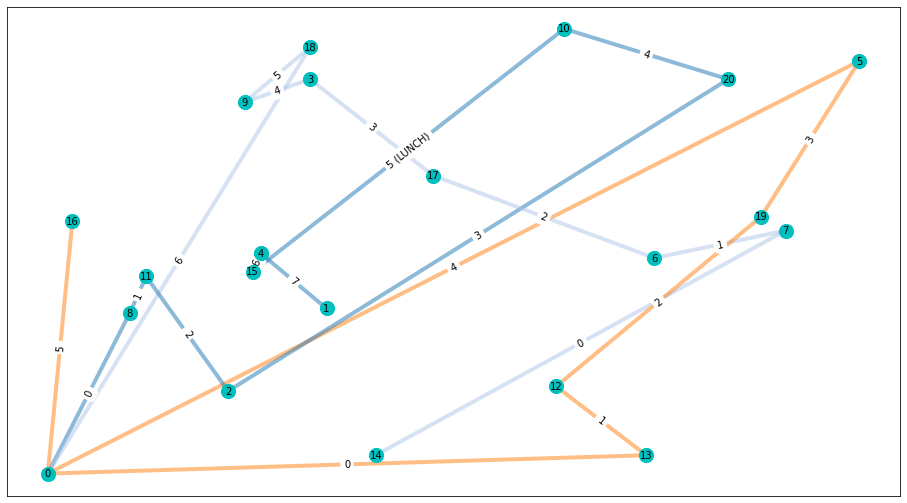

In [24]:
plot_model(domino_list, positions, limit=CLIENTS)